# **1. Import library**

Menginstall semua depencies yang dibutuhkan

In [1]:
!pip install Sastrawi
!pip install tensorflowjs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Text Processing
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Model Saving
import joblib
import json
import tensorflow as tf
import os

plt.style.use('default')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


# **2. Load Dataset**

In [2]:
def load_data():
    """Load dataset dari file CSV"""
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)

    return df

df = load_data()
print("Dataset berhasil dimuat!")
print(f"Shape: {df.shape}")
print("\nKolom:", df.columns.tolist())

Saving CBF_Cleaned.csv to CBF_Cleaned.csv
Dataset berhasil dimuat!
Shape: (236, 9)

Kolom: ['Unnamed: 0', 'nama_tempat', 'rating', 'jumlah_ulasan', 'alamat', 'link', 'thumbnail', 'kategori', 'content']


# **3. Data Wrangling**

## 3.1. Statistics Descriptive

In [3]:
# Ringkasan data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     236 non-null    int64  
 1   nama_tempat    236 non-null    object 
 2   rating         236 non-null    float64
 3   jumlah_ulasan  236 non-null    float64
 4   alamat         236 non-null    object 
 5   link           236 non-null    object 
 6   thumbnail      236 non-null    object 
 7   kategori       236 non-null    object 
 8   content        236 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 16.7+ KB


In [4]:
df.describe()

,Unnamed: 0,rating,jumlah_ulasan
count,236.000000,236.000000,236.000000
mean,143.250000,4.398729,1568.355932
std,88.634229,0.276218,3210.861940
min,0.000000,3.000000,1.000000
25%,64.500000,4.300000,117.750000
50%,142.500000,4.400000,394.500000
75%,217.250000,4.600000,1435.000000
max,294.000000,5.000000,24427.000000


## 3.2. Handling Missing Values

In [5]:
df.isnull().sum()

,0
Unnamed: 0,0
nama_tempat,0
rating,0
jumlah_ulasan,0
alamat,0
link,0
thumbnail,0
kategori,0
content,0


## 3.3. Handling Duplicated Data

In [6]:
df.duplicated().sum()

np.int64(0)

# **4. EDA**

## 4.1. Feature Distribution.

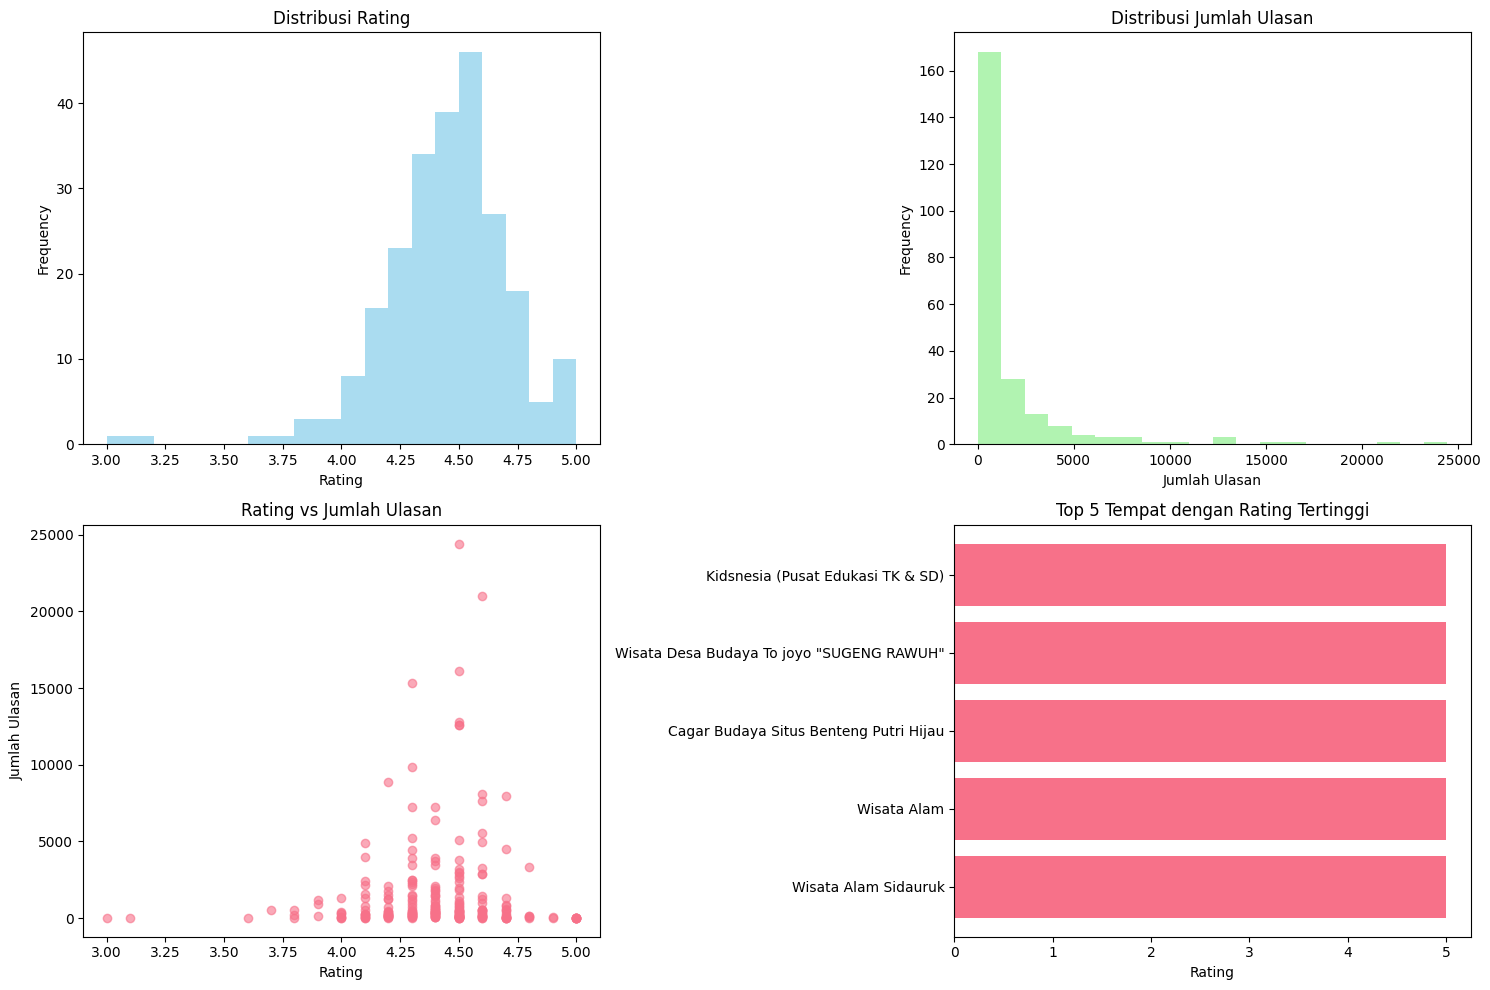

In [10]:
def perform_eda(df):
    """Melakukan analisis data eksploratif"""

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Rating distribution
    axes[0,0].hist(df['rating'], bins=20, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribusi Rating')
    axes[0,0].set_xlabel('Rating')
    axes[0,0].set_ylabel('Frequency')

    # Reviews count distribution
    axes[0,1].hist(df['jumlah_ulasan'], bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Distribusi Jumlah Ulasan')
    axes[0,1].set_xlabel('Jumlah Ulasan')
    axes[0,1].set_ylabel('Frequency')

    # Rating vs Reviews scatter
    axes[1,0].scatter(df['rating'], df['jumlah_ulasan'], alpha=0.6)
    axes[1,0].set_title('Rating vs Jumlah Ulasan')
    axes[1,0].set_xlabel('Rating')
    axes[1,0].set_ylabel('Jumlah Ulasan')

    # Top locations by rating
    top_ratings = df.nlargest(5, 'rating')
    axes[1,1].barh(top_ratings['nama_tempat'], top_ratings['rating'])
    axes[1,1].set_title('Top 5 Tempat dengan Rating Tertinggi')
    axes[1,1].set_xlabel('Rating')

    plt.tight_layout()
    plt.show()

    return df

# Perform EDA
df = perform_eda(df)

# **5. Preprocessing**

In [11]:
class IndonesianTextPreprocessor:
    def __init__(self):
        # Initialize Sastrawi components
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

        # Additional Indonesian stopwords
        self.additional_stopwords = {
            'wisata', 'alam', 'tempat', 'lokasi', 'indonesia', 'sumatera', 'utara',
            'kabupaten', 'kecamatan', 'kec', 'jalan', 'jl', 'desa', 'kelurahan'
        }

    def clean_text(self, text):
        """Membersihkan teks dari karakter khusus"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove URLs
        text = re.sub(r'http\S+|www.\S+', '', text)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def remove_stopwords(self, text):
        """Menghapus stopwords"""
        # Use Sastrawi stopword remover
        text = self.stopword_remover.remove(text)

        # Remove additional stopwords
        words = text.split()
        words = [word for word in words if word not in self.additional_stopwords]

        return ' '.join(words)

    def stem_text(self, text):
        """Melakukan stemming"""
        return self.stemmer.stem(text)

    def preprocess(self, text):
        """Pipeline preprocessing lengkap"""
        text = self.clean_text(text)
        text = self.remove_stopwords(text)
        text = self.stem_text(text)
        return text

# Initialize preprocessor
preprocessor = IndonesianTextPreprocessor()

def preprocess_data(df):
    """Memproses data untuk model"""
    print("="*50)
    print("DATA PREPROCESSING")
    print("="*50)

    # Create processed dataframe
    processed_df = df.copy()

    # Handle missing values
    processed_df['rating'] = processed_df['rating'].fillna(processed_df['rating'].mean())
    processed_df['jumlah_ulasan'] = processed_df['jumlah_ulasan'].fillna(0)
    processed_df['content'] = processed_df['content'].fillna('')
    processed_df['alamat'] = processed_df['alamat'].fillna('')

    # Combine content and address for better feature extraction
    processed_df['combined_text'] = processed_df['content'] + ' ' + processed_df['alamat']

    # Preprocess text
    print("Memproses teks...")
    processed_df['processed_text'] = processed_df['combined_text'].apply(
        lambda x: preprocessor.preprocess(x)
    )

    # Create quality score (combination of rating and review count)
    scaler = MinMaxScaler()
    processed_df['normalized_reviews'] = scaler.fit_transform(
        processed_df[['jumlah_ulasan']]
    ).flatten()
    processed_df['quality_score'] = (
        processed_df['rating'] * 0.7 +
        processed_df['normalized_reviews'] * 0.3
    )

    print("Preprocessing selesai!")
    print(f"Sample processed text: {processed_df['processed_text'].iloc[0][:100]}...")

    return processed_df

# Preprocess data
processed_df = preprocess_data(df)

DATA PREPROCESSING
Memproses teks...
Preprocessing selesai!
Sample processed text: datuk kwala indah sei suka batu bara kwala indah sei suka batu bara...


# **6. Feature Extraction**

In [12]:
def extract_features(processed_df):
    """Ekstraksi fitur menggunakan TF-IDF"""
    print("="*50)
    print("FEATURE EXTRACTION")
    print("="*50)

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,  # Limit features for efficiency
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=1,  # Minimum document frequency
        max_df=0.8,  # Maximum document frequency
        strip_accents='unicode',
        lowercase=True
    )

    # Fit and transform
    tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['processed_text'])

    print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
    print(f"Feature Names (first 10): {tfidf_vectorizer.get_feature_names_out()[:10]}")

    return tfidf_matrix, tfidf_vectorizer

# Extract features
tfidf_matrix, tfidf_vectorizer = extract_features(processed_df)

FEATURE EXTRACTION
TF-IDF Matrix Shape: (236, 1000)
Feature Names (first 10): ['abdul khadir' 'abdullah' 'abdullah lubis' 'aceh' 'aceh aek' 'ade'
 'ade irma' 'aek' 'aek libung' 'aek nalas']


# **7. COMPUTING COSINE SIMILARITY**

In [13]:
def compute_similarity(tfidf_matrix):
    """Menghitung cosine similarity"""
    print("="*50)
    print("COMPUTING COSINE SIMILARITY")
    print("="*50)

    # Compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    print(f"Similarity Matrix Shape: {cosine_sim.shape}")
    print(f"Sample similarities for first item: {cosine_sim[0][:5]}")

    return cosine_sim

# Compute similarity
cosine_sim = compute_similarity(tfidf_matrix)

COMPUTING COSINE SIMILARITY
Similarity Matrix Shape: (236, 236)
Sample similarities for first item: [1.         0.         0.         0.         0.04243175]


# **8. Evaluation**

In [14]:
class TourismRecommender:
    def __init__(self, df, cosine_sim, tfidf_vectorizer):
        self.df = df
        self.cosine_sim = cosine_sim
        self.tfidf_vectorizer = tfidf_vectorizer
        self.indices = pd.Series(df.index, index=df['nama_tempat']).drop_duplicates()

    def get_recommendations(self, place_name, top_n=5):
        """Mendapatkan rekomendasi berdasarkan nama tempat"""
        try:
            # Get index of the place
            idx = self.indices[place_name]

            # Get similarity scores
            sim_scores = list(enumerate(self.cosine_sim[idx]))

            # Sort by similarity (excluding the place itself)
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

            # Get indices of recommended places
            place_indices = [i[0] for i in sim_scores]

            # Create recommendation dataframe
            recommendations = self.df.iloc[place_indices].copy()
            recommendations['similarity_score'] = [score[1] for score in sim_scores]

            return recommendations[['nama_tempat', 'rating', 'jumlah_ulasan',
                                 'alamat', 'similarity_score']]

        except KeyError:
            return f"Tempat '{place_name}' tidak ditemukan dalam dataset."

    def get_recommendations_by_text(self, query_text, top_n=5):
        """Mendapatkan rekomendasi berdasarkan query text"""
        # Preprocess query
        processed_query = preprocessor.preprocess(query_text)

        # Transform query to TF-IDF
        query_tfidf = self.tfidf_vectorizer.transform([processed_query])

        # Compute similarity with all places
        query_sim = cosine_similarity(query_tfidf, tfidf_matrix).flatten()

        # Get top similar places
        similar_indices = query_sim.argsort()[-top_n:][::-1]

        # Create recommendation dataframe
        recommendations = self.df.iloc[similar_indices].copy()
        recommendations['similarity_score'] = query_sim[similar_indices]

        return recommendations[['nama_tempat', 'rating', 'jumlah_ulasan',
                             'alamat', 'similarity_score']]

# Initialize recommender
recommender = TourismRecommender(processed_df, cosine_sim, tfidf_vectorizer)

# **9. Inference**


In [15]:
def test_recommendations():
    """Test sistem rekomendasi"""
    print("="*50)
    print("TESTING RECOMMENDATION SYSTEM")
    print("="*50)

    # Test 1: Recommendation by place name
    print("Test 1: Rekomendasi berdasarkan nama tempat")
    print("-" * 40)
    place_name = processed_df['nama_tempat'].iloc[0]
    print(f"Mencari rekomendasi untuk: {place_name}")

    recommendations = recommender.get_recommendations(place_name, top_n=3)
    print(recommendations)
    print("\n")

    # Test 2: Recommendation by query text
    print("Test 2: Rekomendasi berdasarkan query text")
    print("-" * 40)
    query = "bukit indah pemandangan alam"
    print(f"Query: '{query}'")

    text_recommendations = recommender.get_recommendations_by_text(query, top_n=3)
    print(text_recommendations)
    print("\n")

# Test the system
test_recommendations()

TESTING RECOMMENDATION SYSTEM
Test 1: Rekomendasi berdasarkan nama tempat
----------------------------------------
Mencari rekomendasi untuk: Wisata Alam Datuk
                               nama_tempat  rating  jumlah_ulasan  \
90                 Wisata Danau Palas Asri     4.3           57.0   
204  SIMPANG BODREX (Kuliner Pasar Miring)     4.6           21.0   
47                      Rekreasi Lau Penda     4.2          251.0   

                                                alamat  similarity_score  
90   Lalang, Kec. Medang Deras, Kabupaten Batu Bara...          0.340644  
204  79W8+44Q, Sipare-Pare, Kec. Air Putih, Kabupat...          0.327570  
47   FH44+2M8, Kwala Lau Bicik, Kutalimbaru, Tiang ...          0.166587  


Test 2: Rekomendasi berdasarkan query text
----------------------------------------
Query: 'bukit indah pemandangan alam'
                 nama_tempat  rating  jumlah_ulasan  \
41              Bukit Senyum     4.7          610.0   
0          Wisata Alam Datuk 

# **10. Simpan Model**

## Saved Model

In [16]:
import os, json, numpy as np

# pastikan folder ada
os.makedirs("model", exist_ok=True)

# siapkan data TF-IDF
tv = tfidf_vectorizer

# cast vocabulary_ ke int biasa
vocab_py = {term: int(idx) for term, idx in tv.vocabulary_.items()}

obj = {
    "vocab": vocab_py,
    "idf":   [float(x) for x in tv.idf_],  # pastikan jadi Python float
    "terms": tv.get_feature_names_out().tolist()
}

# dump ke JSON
with open('model/tfidf.json','w') as f:
    json.dump(obj, f, ensure_ascii=False, indent=2)

# simpan similarity matrix sebagai .npy
np.save('model/cosine_sim.npy', cosine_sim)

# jika butuh JSON juga, convert inner ke float
cosine_list = [[float(x) for x in row] for row in cosine_sim]
with open('model/cosine_sim.json','w') as f:
    json.dump(cosine_list, f, ensure_ascii=False, indent=2)


In [17]:
import shutil

# Zip folder model menjadi cbf_encoder.zip
shutil.make_archive('model_cbf', 'zip', 'model')

from google.colab import files
files.download('model_cbf.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>